In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import random
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import mplfinance as mpf

In [2]:
def get_sp500_tickers():
    url = 'https://www.slickcharts.com/sp500'
    html = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).text
    table = pd.read_html(str(BeautifulSoup(html, 'lxml').find('table')))[0]
    return table['Symbol'].str.replace('.', '-', regex=False).tolist()

tickers = get_sp500_tickers()
df = yf.download(tickers, start='2010-01-01', end='2025-04-22', group_by='ticker', auto_adjust=True)

C:\Users\rusla\AppData\Local\Temp\ipykernel_52980\631629297.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(BeautifulSoup(html, 'lxml').find('table')))[0]
[*********************100%***********************]  503 of 503 completed


In [3]:
# Multi to singlular column transformation
df.columns = df.columns.swaplevel(0, 1)
df_flat = df.stack(level=1, future_stack=True).reset_index()
df_flat.columns.name = None
df_flat.columns = [col if not isinstance(col, tuple) else col[-1] for col in df_flat.columns]
df_flat.head()

,Date,Ticker,Open,High,Low,Close,Volume
0,2010-01-04,OTIS,NaN,NaN,NaN,NaN,NaN
1,2010-01-04,AMZN,6.812500,6.830500,6.657000,6.695000,151998000.0
2,2010-01-04,MSFT,23.006112,23.366756,22.983571,23.254055,38409100.0
3,2010-01-04,IRM,8.628728,8.692812,8.549566,8.628728,995548.0
4,2010-01-04,CRL,33.740002,33.810001,33.259998,33.570000,1000600.0


In [4]:
df_flat.dropna(inplace=True)
df_flat.isnull().sum()

Date      0
Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## Technical Indicators

- __RSI (Relative Strength Index):__ Measures the speed and magnitude of recent price changes to identify overbought (>70) or oversold (<30) conditions.

    - If RSI > 50 then uptrend is gaining strength
    - If RSI < 50 then momentum is weakening

<br>

- __MACD (Moving Average Convergence Divergence):__ Captures the difference between short and long term momentum via EMAs.

    - MACD = EMA12 - EMA26
    - Signal line = EMA9 of MACD
    - macd > signal = bullish momentum

<br>

- __ATR (Average True Range):__  Is a volatility indicator that reflects the average price variation of an asset.

    - Calculates the maximum of high-low, high-previous close, and low-previous close
    - Averages this over a rolling window, usually set to 14 days
    - Higher ATR can indicate breakout potential or stop-loss placement zones

<br>

- __CCI (Commodity Channel Index):__ Detects price deviations from a statistical mean.

    - Computes the typical price = (High + Low + Close) / 3
    - Measures how far the typical price deviates from its moving average
    - CCI > +100 suggests strong bullish deviation
    - CCI < -100 implies a potential trend reversal

<br>

- __HMA (Hull Moving Average):__ Is a smoother, faster reacting moving average used to reduce lag.

    - Combines weighted averages of two rolling means
    - Applies a square root weighted smoothing

In [7]:
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(span=window, adjust=False).mean()
    avg_loss = loss.ewm(span=window, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(df):
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

def calculate_atr(df, period=14):
    high_low = df['High'] - df['Low']
    high_close = (df['High'] - df['Close'].shift()).abs()
    low_close = (df['Low'] - df['Close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

def calculate_cci(df, period=20):
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma = tp.rolling(window=period).mean()
    mad = tp.rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))))
    cci = (tp - sma) / (0.015 * mad)
    return cci

def calculate_hma(close, period=20):
    half = close.rolling(window=period//2).mean()
    full = close.rolling(window=period).mean()
    raw_hma = 2 * half - full
    hma = raw_hma.rolling(window=int(np.sqrt(period))).mean()
    return hma


## Feature Engineering

- __EMA10, EMA20, EMA50, EMA200:__ Exponential moving averages over different spans, these provide smoothed price trends, with the 50/200 pair used to detect "golden cross" signals.

- __momentum_5:__ Percentage change over the last 5 days, a simple measure of short term momentum or trend acceleration.

- __ema_distance:__ Difference between EMA50 and EMA200, helps quantify how far the two EMAs have diverged.

- __ema50_slope:__ 5 day slope of the EMA50 line, provides insight into the trajectory and speed of trend development.

- __price_ema200_dist:__ Distance between the current close and EMA200.

- __EMA50_prev/EMA200_prev:__ Shifted versions of EMA50 and EMA200, used to identify crossovers.

- __RSI_14:__ 14 day Relative Strength Index, gauges overbought or oversold conditions.

- __MACD/MACD_signal:__ MACD and its signal line.

- __macd_diff:__ Difference between MACD and its signal line, indicates strength of the MACD trend.

- __ATR_14:__ Average True Range over 14 days, measuring volatility.

- __CCI_20:__ Commodity Channel Index over 20 days, another momentum indicator.

- __BB_MID/BB_UPPER/BB_LOWER:__ Bollinger Bands based on 20 day mean and standard deviation.

- __HMA_20:__ Hull Moving Average with 20 period window.

<br>

__Labeling Strategy:__ Used a hybrid logic for labeling crossover signals as profitable (1) or not profitable (0)
- __forward_return:__ The 10 day forward return is calculated as the percentage return from the current date to 10 trading days ahead.
- __Label = 1:__
    - If the forward return exceeds +3% OR
    - If the crossover is supported by bullish MACD and RSI momentum (MACD > MACD Signal & RSI > 50)
- __Label = 0:__ All other cases

- *Why did I end up using this strategy over a standard label that took `forward_return` > 0.3?*
    - It mislabeled "slow" crossovers that took longer to become profitable as "0"
    - Mislabeled "bad" crossovers as good due to short term volatility
    - Saw many signals labeled as "bad" were actually good in hindsight if held longer, also saw "good" labeled signals showing brief momentum and then failing


In [6]:
# FEATURE ENGINEERING
df_flat['EMA10'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
df_flat['EMA20'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
df_flat['EMA50'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=50).mean())
df_flat['EMA200'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=200).mean())

df_flat['momentum_5'] = df_flat.groupby('Ticker')['Close'].pct_change(5, fill_method=None)

df_flat['ema_distance'] = df_flat['EMA50'] - df_flat['EMA200']

df_flat['ema50_slope'] = df_flat.groupby('Ticker')['EMA50'].diff(5)

df_flat['price_ema200_dist'] = df_flat['Close'] - df_flat['EMA200']

df_flat['EMA50_prev'] = df_flat.groupby('Ticker')['EMA50'].shift(1)
df_flat['EMA200_prev'] = df_flat.groupby('Ticker')['EMA200'].shift(1)

df_flat['RSI_14'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: compute_rsi(x))

df_flat[['MACD', 'MACD_signal']] = df_flat.groupby('Ticker').apply(
    lambda x: pd.DataFrame({
        'MACD': calculate_macd(x)[0],
        'MACD_signal': calculate_macd(x)[1]
    }, index=x.index)
).reset_index(drop=True)

df_flat['macd_diff'] = df_flat['MACD'] - df_flat['MACD_signal']

df_flat['ATR_14'] = df_flat.groupby('Ticker').apply(calculate_atr).reset_index(level=0, drop=True)

df_flat['CCI_20'] = df_flat.groupby('Ticker').apply(calculate_cci).reset_index(level=0, drop=True)

df_flat['BB_MID'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
df_flat['BB_STD'] = df_flat.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).std())
df_flat['BB_UPPER'] = df_flat['BB_MID'] + 2 * df_flat['BB_STD']
df_flat['BB_LOWER'] = df_flat['BB_MID'] - 2 * df_flat['BB_STD']

df_flat['HMA_20'] = df_flat.groupby('Ticker')['Close'].transform(calculate_hma)

df_flat['crossover'] = (
    (df_flat['EMA50_prev'] < df_flat['EMA200_prev']) &
    (df_flat['EMA50'] > df_flat['EMA200'])
)

df_flat['forward_return'] = df_flat.groupby('Ticker')['Close'].shift(-10) / df_flat['Close'] - 1


df_flat['label'] = np.where(
    (df_flat['forward_return'] > 0.03),
    1,
    np.where(
        (df_flat['MACD'] > df_flat['MACD_signal']) & (df_flat['RSI_14'] > 50),
        1,
        0
    )
)   

C:\Users\rusla\AppData\Local\Temp\ipykernel_52980\1616348723.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_flat[['MACD', 'MACD_signal']] = df_flat.groupby('Ticker').apply(
C:\Users\rusla\AppData\Local\Temp\ipykernel_52980\1616348723.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_flat['ATR_14'] = df_flat.groupby('Ticker').apply(calculate_atr).reset_index(level=0, drop=True)
C:\Users\rusla\

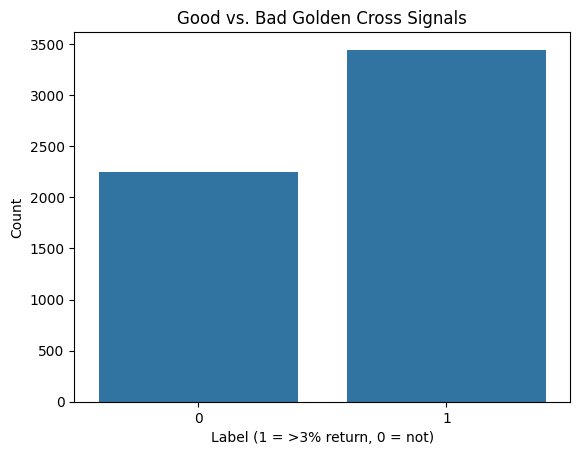

In [9]:
sns.countplot(x='label', data=df_flat[df_flat['crossover']])
plt.title("Good vs. Bad Golden Cross Signals")
plt.xlabel("Label (1 = >3% return, 0 = not)")
plt.ylabel("Count")
plt.show()


#### The distribution of labels shows a reasonably healthy balance between profitable and non-profitable EMA crossovers. Its intentional for both "good" and "bad" crossover outcomes to be represented so that the classifier can effectively learn the distinguishing patterns between successful and unsuccessful signals. 

### Viewing Bad and Good crosses for one ticker

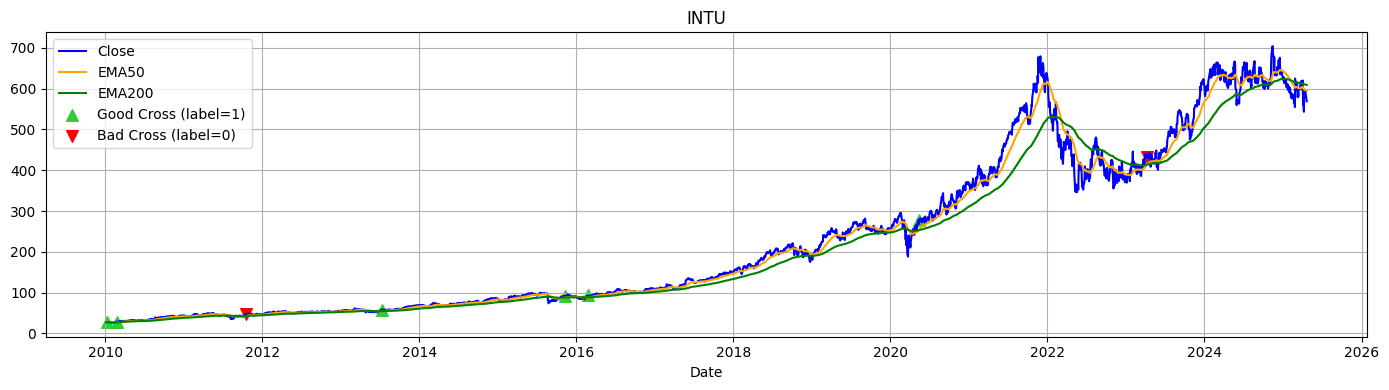

In [20]:
tickers_to_plot = ['INTU']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 4), sharex=True)

ticker = tickers_to_plot[0]
stock_df = df_flat[df_flat['Ticker'] == ticker].copy()
crosses = stock_df[stock_df['crossover']]
good = crosses[crosses['label'] == 1]
bad = crosses[crosses['label'] == 0]

ax.plot(stock_df['Date'], stock_df['Close'], label='Close', color='blue')
ax.plot(stock_df['Date'], stock_df['EMA50'], label='EMA50', color='orange')
ax.plot(stock_df['Date'], stock_df['EMA200'], label='EMA200', color='green')
ax.scatter(good['Date'], good['Close'], label='Good Cross (label=1)', color='limegreen', marker='^', s=70)
ax.scatter(bad['Date'], bad['Close'], label='Bad Cross (label=0)', color='red', marker='v', s=70)

ax.set_title(f"{ticker}")
ax.grid(True)
ax.legend(loc='upper left')
plt.xlabel("Date")
plt.tight_layout()
plt.show()


##### We can see the last label is improperly labeled. This is due to the stock being in a consolidation period where the price is moving sideaways, additional labeling logic would have to be introduced for these type of scenarios 

### Viewing Bad and Good crosses, MACD, and RSI indicators for a ticker 

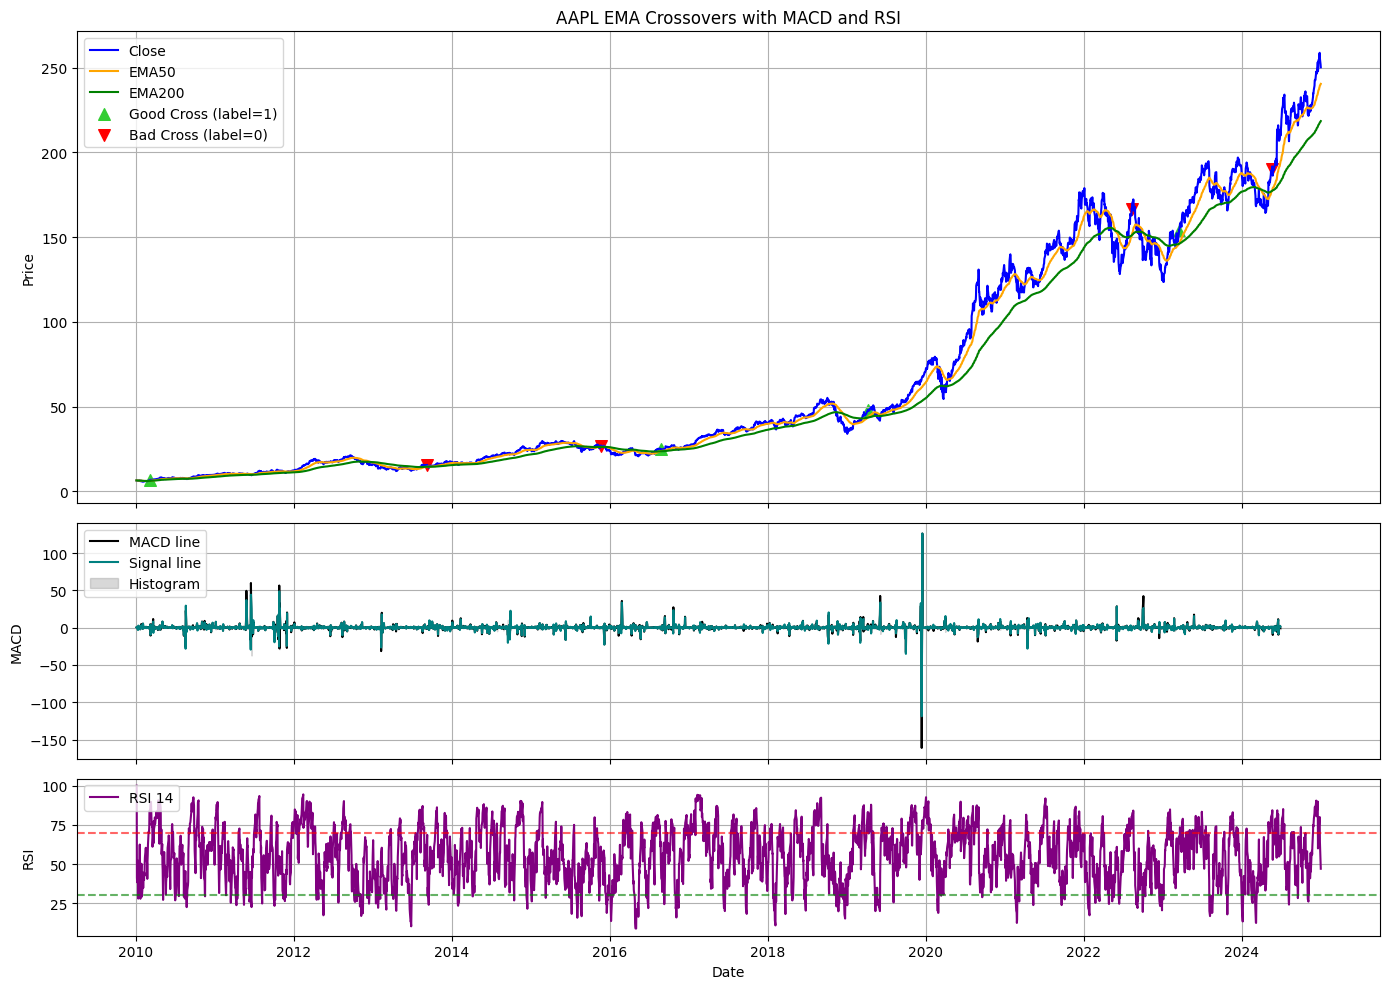

In [21]:
sample_ticker = 'AAPL'
stock_df = df_flat[df_flat['Ticker'] == sample_ticker].copy()

# Filter for time frame
stock_df = stock_df[(stock_df['Date'] >= '2010-01-01') & (stock_df['Date'] <= '2025-01-01')]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True,
                                    gridspec_kw={'height_ratios': [3, 1.5, 1]})

ax1.plot(stock_df['Date'], stock_df['Close'], label='Close', color='blue')
ax1.plot(stock_df['Date'], stock_df['EMA50'], label='EMA50', color='orange')
ax1.plot(stock_df['Date'], stock_df['EMA200'], label='EMA200', color='green')

crosses = stock_df[stock_df['crossover']]
good = crosses[crosses['label'] == 1]
bad = crosses[crosses['label'] == 0]

ax1.scatter(good['Date'], good['Close'], label='Good Cross (label=1)', color='limegreen', marker='^', s=70)
ax1.scatter(bad['Date'], bad['Close'], label='Bad Cross (label=0)', color='red', marker='v', s=70)

ax1.set_title(f"{sample_ticker} EMA Crossovers with MACD and RSI")
ax1.set_ylabel("Price")
ax1.legend(loc='upper left')
ax1.grid(True)

# MACD
ax2.plot(stock_df['Date'], stock_df['MACD'], label='MACD line', color='black')
ax2.plot(stock_df['Date'], stock_df['MACD_signal'], label='Signal line', color='teal')
ax2.fill_between(stock_df['Date'], stock_df['MACD'] - stock_df['MACD_signal'], color='gray', alpha=0.3, label='Histogram')

ax2.set_ylabel("MACD")
ax2.legend(loc='upper left')
ax2.grid(True)

# RSI
ax3.plot(stock_df['Date'], stock_df['RSI_14'], label='RSI 14', color='purple')
ax3.axhline(70, linestyle='--', color='red', alpha=0.6)
ax3.axhline(30, linestyle='--', color='green', alpha=0.6)

ax3.set_ylabel("RSI")
ax3.set_xlabel("Date")
ax3.legend(loc='upper left')
ax3.grid(True)

plt.tight_layout()
plt.show()


### Viewing 3 different tickers at random

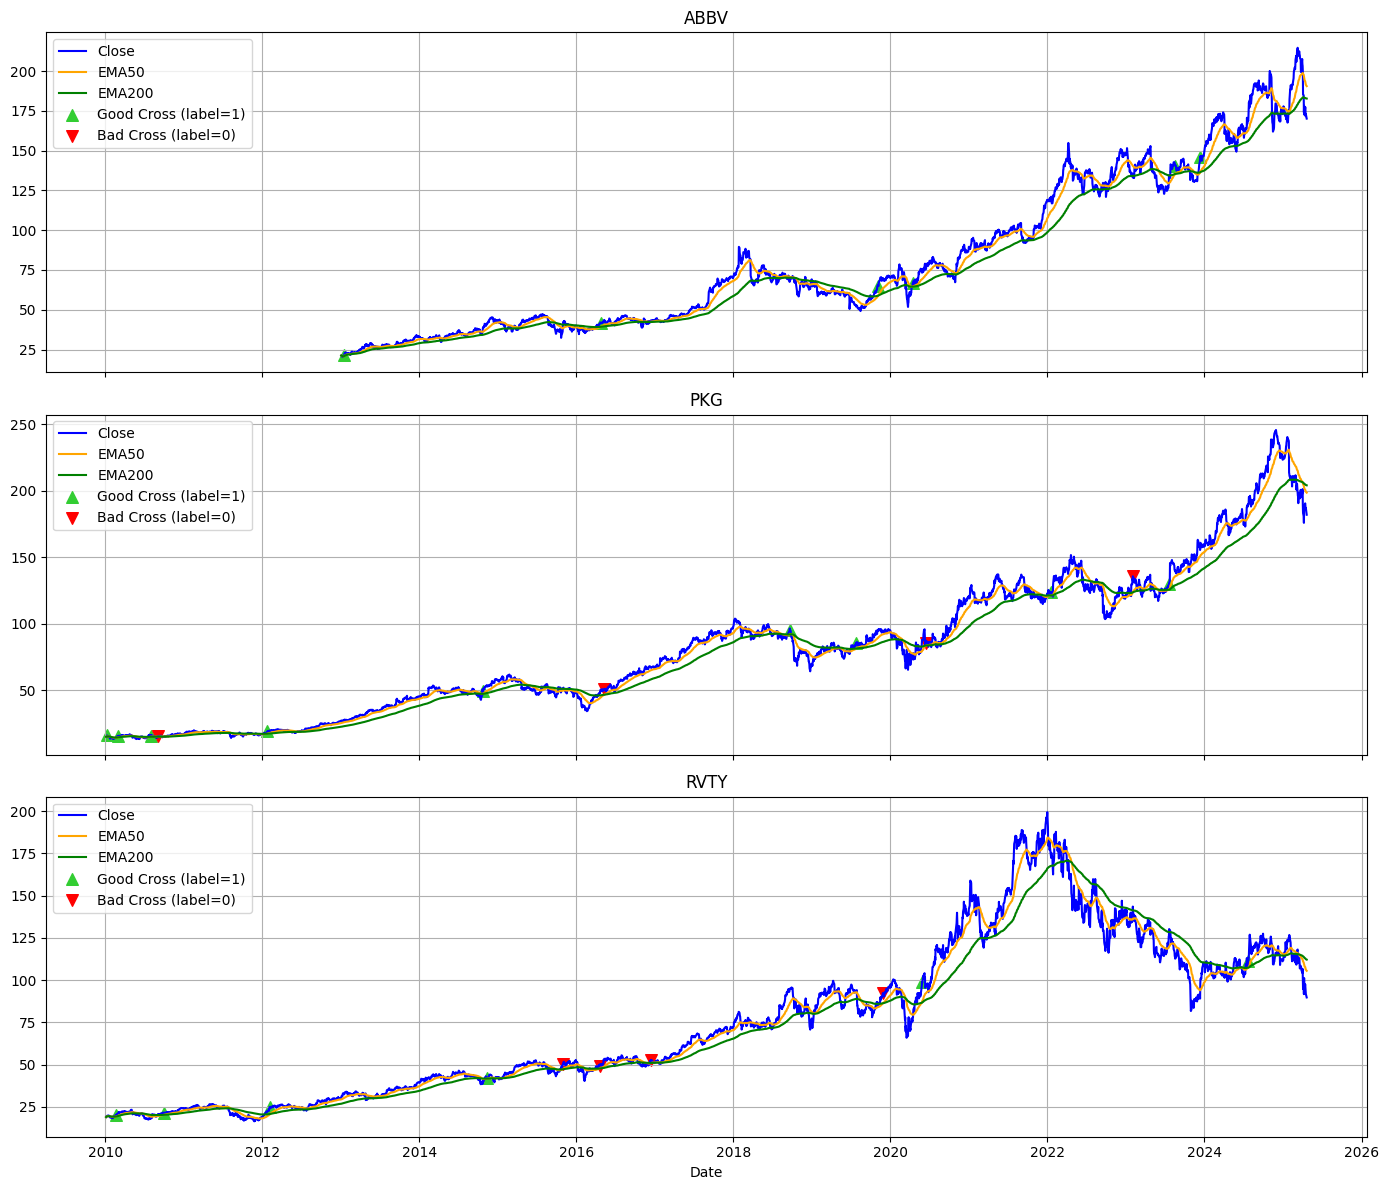

In [19]:
tickers_with_crosses = df_flat[df_flat['crossover']]['Ticker'].unique()
tickers_to_plot = random.sample(list(tickers_with_crosses), 3)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

for i, ticker in enumerate(tickers_to_plot):
    ax = axes[i]
    stock_df = df_flat[df_flat['Ticker'] == ticker].copy()
    crosses = stock_df[stock_df['crossover']]
    good = crosses[crosses['label'] == 1]
    bad = crosses[crosses['label'] == 0]

    ax.plot(stock_df['Date'], stock_df['Close'], label='Close', color='blue')
    ax.plot(stock_df['Date'], stock_df['EMA50'], label='EMA50', color='orange')
    ax.plot(stock_df['Date'], stock_df['EMA200'], label='EMA200', color='green')

    ax.scatter(good['Date'], good['Close'], label='Good Cross (label=1)', color='limegreen', marker='^', s=70)
    ax.scatter(bad['Date'], bad['Close'], label='Bad Cross (label=0)', color='red', marker='v', s=70)

    ax.set_title(f"{ticker}")
    ax.grid(True)
    ax.legend(loc='upper left')

plt.xlabel("Date")
plt.tight_layout()
plt.show()
